# **Import Library**

In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# **Load Dataset**

In [2]:
raw_data_path = Path.cwd().parent / "data" / "raw_data"

files = [
    f for f in raw_data_path.iterdir()
    if f.is_file() and f.suffix.lower() in (".csv", ".xlsx")
]

print("List Files:")
for f in files:
    print("-", f.name)

print(f"\nCount files: {len(files)} files")

List Files:
- crack fault state-Vw=4.5.csv
- crack fault-Vw=4.csv
- Crack Fault-Vw=5.4.csv
- Crack Fault-Vw=5.csv
- Crack State-Vw=1.3.csv
- Crack state-Vw=2.8.csv
- Crack state-Vw=3.3.csv
- Erosion fault state-Vw=1.3.csv
- Erosion fault state-Vw=2.1.csv
- Erosion fault state-Vw=2.8.csv
- Erosion Fault state-Vw=3.4.csv
- Erosion Fault State-Vw=4.2.csv
- Erosion fault state-Vw=5.3.csv
- Erosion Fault state-Vw=5.csv
- H for Vw=2.3.csv
- H-for Vw=1.3.csv
- H-for-Vw=3.2.csv
- H-for-Vw=3.7.csv
- H-for-Vw=4.5.csv
- H-for-Vw=5.csv
- H-Vw=5.3.csv
- twist fault when Vw=1.3.xlsx
- twist fault when Vw=4.7.xlsx
- twist fault when Vw=5.3.xlsx
- twist fault when Vw=5.xlsx
- twist fault when Vwind=4.xlsx
- twist faultwhenVw=3.2.xlsx
- twsist faut when Vw=2.xlsx
- unbalance fault state-Vw=3.4.csv
- unbalance fault state-Vw=4.2.csv
- unbalance fault state-Vw=4.7.csv
- unbalance fault state-Vw=5.csv
- unbalance fault state=Vw=2.3.csv
- UnbalanceState-Vw=1.3.csv
- unbalnce fault state-Vw=3.csv

Count fil

# **Create "label" and "wind_speed"**

In [3]:
label_names = [
    "Blade Healthy Condition",
    "Blade Surface Erosion Fault",
    "Blade Crack Fault",
    "Blade Mass Imbalance Fault",
    "Blade Twist Fault"
]

labels = []

for file in files:
    name = file.name.lower()

    if any(k in name for k in ["h-", "h for", "healthy"]):
        label = 0
    elif "erosion" in name:
        label = 1
    elif "crack" in name:
        label = 2
    elif any(k in name for k in ["unbalance", "unbalnce", "imbalance"]):
        label = 3
    elif any(k in name for k in ["twist", "twsist"]):
        label = 4
    else:
        raise ValueError(f"Cannot assign label to file: {file.name}")

    labels.append(label)

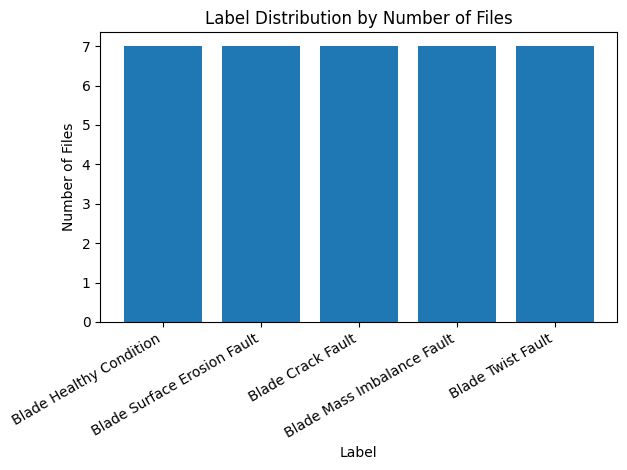

In [4]:
label_series = pd.Series(labels)
label_counts = label_series.value_counts().sort_index()

plt.figure()
plt.bar(
    [label_names[i] for i in label_counts.index],
    label_counts.values
)
plt.xlabel("Label")
plt.ylabel("Number of Files")
plt.title("Label Distribution by Number of Files")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [5]:
wind_speeds = []

for file in files:
    match = re.search(
        r"(?:v ?wind|v ?w|vw|[._-])\s*=?\s*([\d]+\.?\d*)",
        file.name.lower()
    )

    if match:
        try:
            wind_speed = float(match.group(1))
        except ValueError:
            wind_speed = 0.0
    else:
        wind_speed = 0.0

    wind_speeds.append(wind_speed)

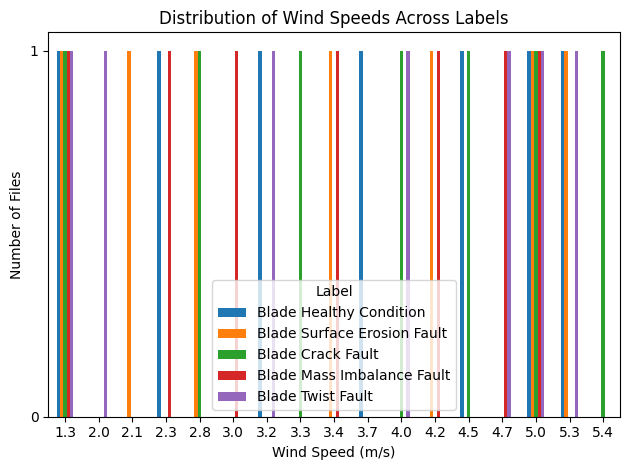

In [6]:
pivot = (
    pd.DataFrame({"label": labels, "wind_speed": wind_speeds})
      .value_counts(["wind_speed", "label"])
      .unstack(fill_value=0)
)

pivot.columns = [label_names[i] for i in pivot.columns]

ax = pivot.plot(kind="bar")
ax.set(
    xlabel="Wind Speed (m/s)",
    ylabel="Number of Files",
    title="Distribution of Wind Speeds Across Labels"
)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=0)
plt.legend(title="Label")
plt.tight_layout()
plt.show()

# **Create "time" and "amplitude"**

In [7]:
times = []
amplitudes = []

for file in files:
    file_path = raw_data_path / file.name

    if file.suffix.lower() == ".csv":
        temp_df = pd.read_csv(file_path)
    elif file.suffix.lower() == ".xlsx":
        temp_df = pd.read_excel(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file.name}")

    if {"Time - Voltage_1", "Amplitude - Voltage_1"}.issubset(temp_df.columns):
        t = temp_df["Time - Voltage_1"].astype(float)
        a = temp_df["Amplitude - Voltage_1"].astype(float) * 10

    elif {"Time - sec", "Amplitude - g"}.issubset(temp_df.columns):
        t = temp_df["Time - sec"].astype(float)
        a = temp_df["Amplitude - g"].astype(float)

    elif "Time - Voltage_1;Amplitude - Voltage_1" in temp_df.columns:
        ta = temp_df["Time - Voltage_1;Amplitude - Voltage_1"].str.split(";", expand=True).dropna()
        ta = ta[(ta[0].str.strip() != "") & (ta[1].str.strip() != "")]
        t = ta[0].astype(float)
        a = ta[1].astype(float) * 10

    elif "Time - sec;Amplitude - g" in temp_df.columns:
        ta = temp_df["Time - sec;Amplitude - g"].str.split(";", expand=True).dropna()
        ta = ta[(ta[0].str.strip() != "") & (ta[1].str.strip() != "")]
        t = ta[0].astype(float)
        a = ta[1].astype(float)

    else:
        raise ValueError(f"Missing required columns in file: {file.name}")

    times.append(t.tolist())
    amplitudes.append(a.tolist())

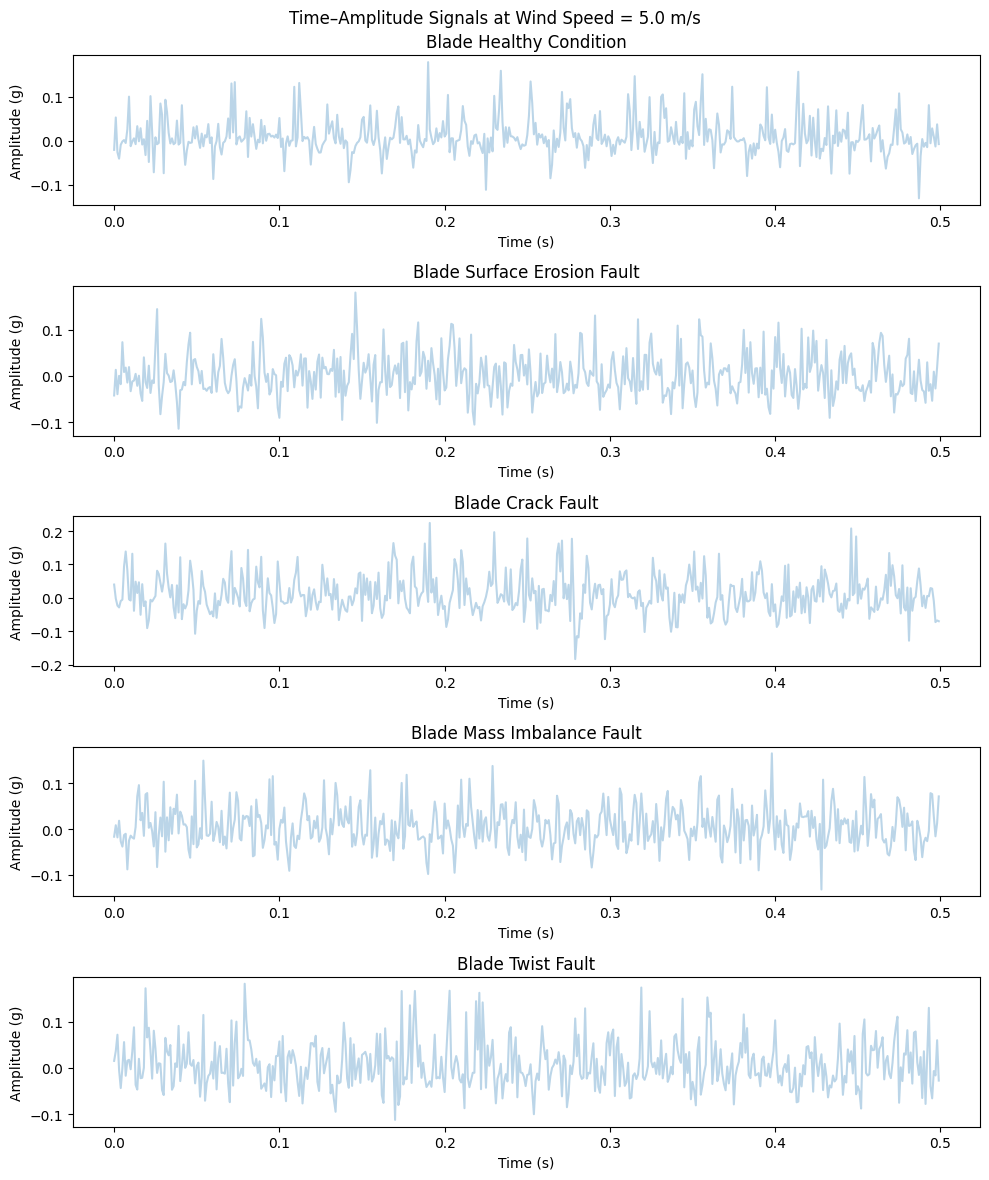

In [8]:
TARGET_WIND = 5.0

fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for lbl in range(5):
    ax = axes[lbl]

    for t, a, l, w in zip(times, amplitudes, labels, wind_speeds):
        if l == lbl and w == TARGET_WIND:
            ax.plot(t, a, alpha=0.3)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (g)")
    ax.set_title(label_names[lbl])

plt.suptitle("Time–Amplitude Signals at Wind Speed = 5.0 m/s", y=0.98)
plt.tight_layout()
plt.show()

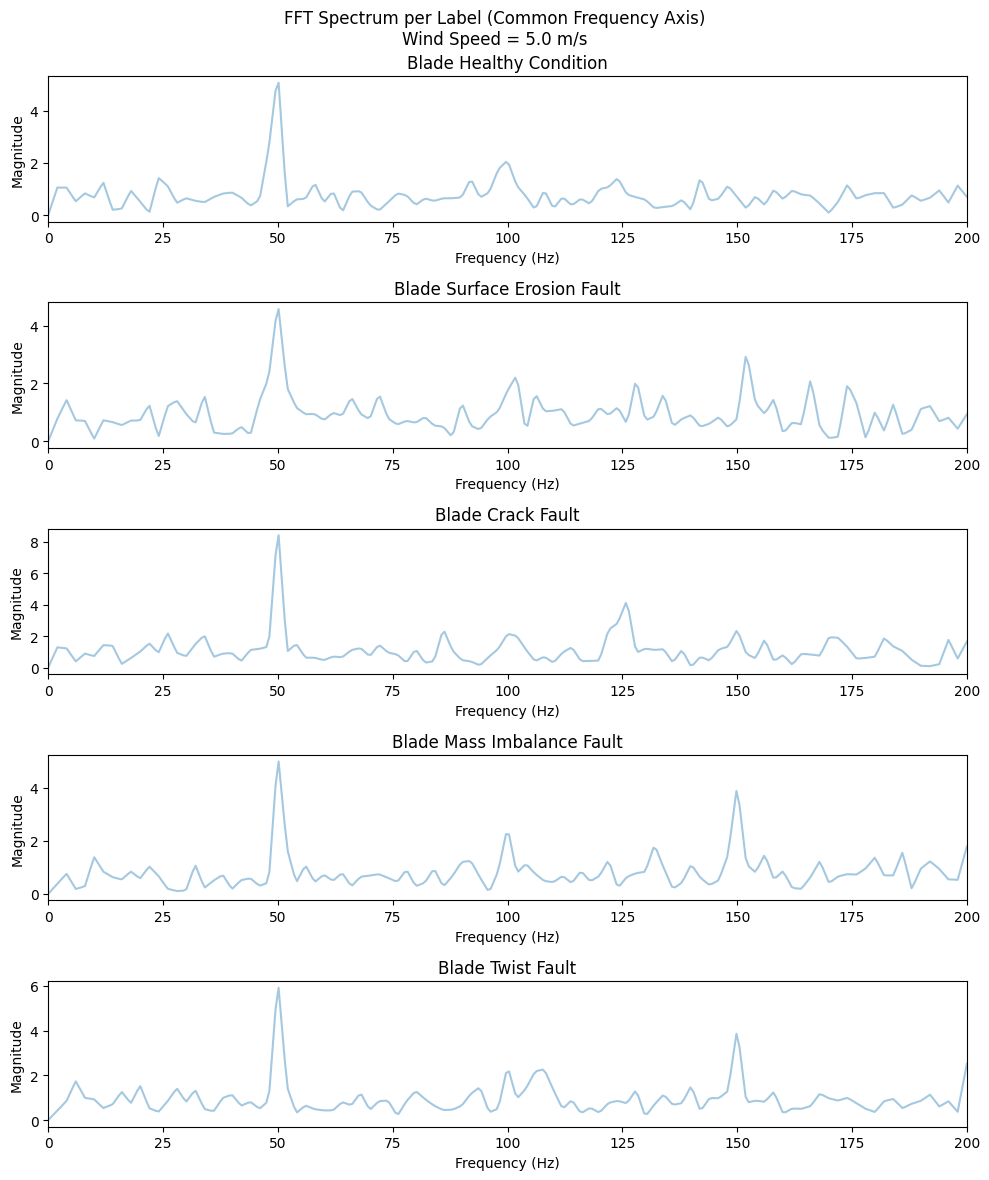

In [9]:
FS = 1000
TARGET_WIND = 5.0
COMMON_FREQ = np.linspace(0, 200, 300)

fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for lbl in range(5):
    ax = axes[lbl]

    for a, l, w in zip(amplitudes, labels, wind_speeds):
        if l == lbl and w == TARGET_WIND:
            a = np.asarray(a, dtype=float)
            a -= np.mean(a)

            fft_vals = np.abs(np.fft.rfft(a))
            freqs = np.fft.rfftfreq(len(a), d=1 / FS)

            fft_interp = np.interp(COMMON_FREQ, freqs, fft_vals)

            ax.plot(COMMON_FREQ, fft_interp, alpha=0.4)

    ax.set_xlim(0, 200)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude")
    ax.set_title(label_names[lbl])

plt.suptitle("FFT Spectrum per Label (Common Frequency Axis)\nWind Speed = 5.0 m/s", y=0.98)
plt.tight_layout()
plt.show()

# **Merge Columns into a Dataset**

In [10]:
cleaned_df = (
    pd.DataFrame({
        "time": times,
        "amplitude": amplitudes,
        "wind_speed": wind_speeds,
        "label": labels,
    })
    .explode(["time", "amplitude"])
    .reset_index(drop=True)
)

cleaned_df.head()

,time,amplitude,wind_speed,label
0,0.0,0.000322,4.5,2
1,0.001,-0.01392,4.5,2
2,0.002,0.06323,4.5,2
3,0.003,-0.00476,4.5,2
4,0.004,0.05196,4.5,2


# **Export Cleaned Dataset**

In [11]:
cleaned_data_path = Path.cwd().parent / 'data' / 'cleaned_data' / 'cleaned_wind_turbine_data.csv'

print("Cleaned Dataset Saved!")

cleaned_df.to_csv(cleaned_data_path, index=False)

Cleaned Dataset Saved!
